In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_jac_hvp_fun

import paragami

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Load data

In [3]:
data = np.load('../simulated_data/simulated_structure_data_nobs20_nloci50_npop4.npz')
g_obs = np.array(data['g_obs'])

In [4]:
n_obs = g_obs.shape[0]
n_loci = g_obs.shape[1]

# Get prior

In [5]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [6]:
k_approx = 4

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [8]:
use_logitnormal_sticks = True

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (50, 4, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_propn_mean] = NumericArrayPattern (20, 3) (lb=-inf, ub=inf)
	[ind_mix_stick_propn_info] = NumericArrayPattern (20, 3) (lb=0.0001, ub=inf)


In [28]:
vb_params_dict_random = vb_params_paragami.random(key=jax.random.PRNGKey(41))

In [29]:
structure_model_lib.get_kl(g_obs, vb_params_dict_random, prior_params_dict,
                                    gh_loc, gh_weights)

DeviceArray(2117.82905805, dtype=float64)

In [30]:
# get initial moments from vb_params
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(
            vb_params_dict_random, gh_loc, gh_weights)

vb_params_dict_random['pop_freq_beta_params'] = \
    cavi_lib.update_pop_beta(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    e_log_sticks, e_log_1m_sticks,
                    prior_params_dict['dp_prior_alpha'],
                    prior_params_dict['allele_prior_alpha'],
                    prior_params_dict['allele_prior_beta'])[2]

structure_model_lib.get_kl(g_obs, vb_params_dict_random, prior_params_dict,
                                    gh_loc, gh_weights)

DeviceArray(1807.1358638, dtype=float64)

## Initialize 

In [31]:
vb_params_dict_nmf_init = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 3421)

In [38]:
structure_model_lib.get_kl(g_obs, vb_params_dict_nmf_init, prior_params_dict,
                                    gh_loc, gh_weights)

DeviceArray(3247.10565251, dtype=float64)

In [14]:
# get initial moments from vb_params
e_log_sticks, e_log_1m_sticks, \
    e_log_pop_freq, e_log_1m_pop_freq = \
        structure_model_lib.get_moments_from_vb_params_dict(
            vb_params_dict_nmf_init, gh_loc, gh_weights)

vb_params_dict_nmf_init['pop_freq_beta_params'] = \
    cavi_lib.update_pop_beta(g_obs,
                    e_log_pop_freq, e_log_1m_pop_freq,
                    e_log_sticks, e_log_1m_sticks,
                    prior_params_dict['dp_prior_alpha'],
                    prior_params_dict['allele_prior_alpha'],
                    prior_params_dict['allele_prior_beta'])[2]

structure_model_lib.get_kl(g_obs, vb_params_dict_nmf_init, prior_params_dict,
                                    gh_loc, gh_weights)

DeviceArray(1836.17916075, dtype=float64)

In [15]:
true_ind_admix_propn = data['true_ind_admix_propn']
true_pop_allele_freq = data['true_pop_allele_freq']

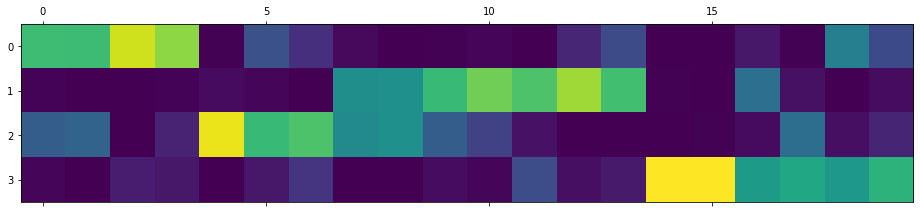

In [16]:
# truth
plt.matshow(true_ind_admix_propn.T)

In [23]:
e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_params_dict_nmf_init['ind_mix_stick_propn_mean'], 
                            vb_params_dict_nmf_init['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

e_pop_freq = modeling_lib.get_e_beta(vb_params_dict_nmf_init['pop_freq_beta_params'])

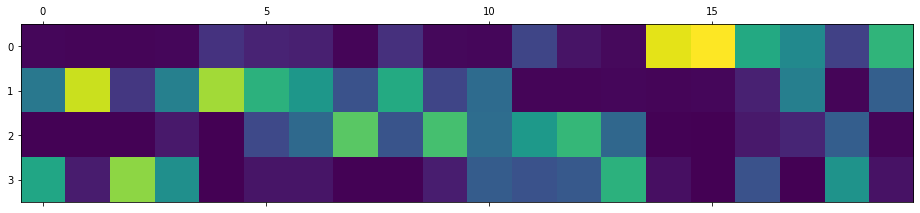

In [25]:
plt.matshow(e_ind_admix.T)

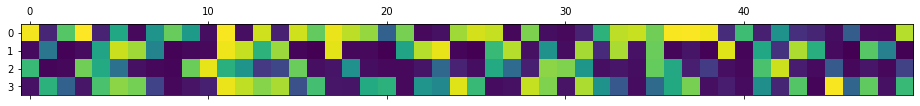

In [26]:
plt.matshow(e_pop_freq.T)

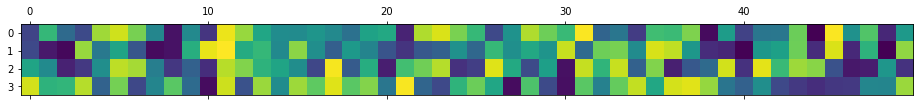

In [27]:
plt.matshow(true_pop_allele_freq.T)